Parameter Fitting
===

Having trained the density ratios in the `Preselection_withNN.ipynb` notebook, we are ready for the final parameter fitting step of the workflow.

We defined Signal Region (SR) and Control Region (CR) channels in the `Neural_Likelihood_Ratio_Estimation.ipynb` notebook, using a preselection NN that isolates signal-rich phase space for the NSBI fitting, with a background-rich phase space used for detailed validations as well as constraining background parameters. We also isolated a Binned Signal Region where the signal cross-section dominated that of the background, for a binned Poisson fit to further boost sensitivity in poorly modeled, but signal-dominant, phase space.

In [1]:
import os, sys, importlib
# sys.path.append('../')

import nsbi_common_utils
from nsbi_common_utils import plotting, training, \
inference, datasets, configuration, workspace_builder, model
import glob
import numpy as np

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import pickle
import matplotlib.pyplot as plt
import yaml

from nsbi_common_utils.inference import inference, plot_NLL_scans

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

hep.style.use(hep.style.ATLAS)


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/src/nsbi_common_utils/plotting.py:10: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-11-05 12:03:00.713805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-05 12:03:00.733752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-05 12:03:00.740193: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-05 12:03:00.755044: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CP

Building a Workspace
--

Now it is time to write the statistical model into a serialized specification file, referred to as a `workspace` in `pyhf` and `HistFactory` jargon. It can be built from the config file using the `nsbi_common_utils.workspace_builder` class, but also can be provided standalone, following the specific schema defined here.

In [2]:
importlib.reload(sys.modules['nsbi_common_utils.workspace_builder'])
from nsbi_common_utils import workspace_builder

workspace_builder_hist = nsbi_common_utils.workspace_builder.WorkspaceBuilder(config_path = './config_hist.yml')
workspace_builder_nsbi = nsbi_common_utils.workspace_builder.WorkspaceBuilder(config_path = './config.yml')

In [3]:
workspace_hist = workspace_builder_hist.build()
workspace_nsbi = workspace_builder_nsbi.build()

The Model
-

Now lets take a look at how this workspace looks like. It is almost identical to the `pyhf` workspace schema, except it allows for analysis regions with NSBI-type fits. 

In [4]:
workspace_nsbi

{'channels': [{'name': 'CR',
   'type': 'binned',
   'samples': [{'name': 'htautau',
     'data': [0.0013407781, 0.74715865, 13.067466, 150.24959],
     'modifiers': [{'name': 'mu_htautau', 'data': None, 'type': 'normfactor'},
      {'name': 'JES',
       'type': 'normplusshape',
       'data': {'hi_data': [1.0, 1.0034748, 1.0010682, 0.9844707],
        'lo_data': [1.4999533, 0.9765293, 1.0002635, 1.0192274]}},
      {'name': 'TES',
       'type': 'normplusshape',
       'data': {'hi_data': [1.0, 0.97021765, 0.99711764, 0.9598405],
        'lo_data': [1.0, 1.0413483, 1.0015804, 1.0440967]}}]},
    {'name': 'ttbar',
     'data': [13.598122, 3989.8796, 23201.07, 10541.463],
     'modifiers': [{'name': 'mu_ttbar', 'data': None, 'type': 'normfactor'},
      {'name': 'JES',
       'type': 'normplusshape',
       'data': {'hi_data': [1.0320369, 1.0150456, 1.002463, 0.9890281],
        'lo_data': [0.96364826, 0.98511267, 0.99741846, 1.0104861]}},
      {'name': 'TES',
       'type': 'normplus

The `nsbi_common_utils.model` can take as input this model defined as a workspace and builds a likelihood model in JAX, with just-in-time (JIT) compilation. 

NB: In the model we are fitting, we introduce floating parameters in the config file that are associated with background normalization: 

$$\sum_c f_c(\mu) \cdot \nu_c  \cdot \frac{p_c\left(x\right)}{p_{ref}(x)} = \mu_{higgs} \cdot \nu_{H \to \tau\tau}(\mu) \cdot  \frac{p_{H \to \tau\tau}\left(x\right)}{p_{ref}(x)} + \mu_{t\bar{t}} \cdot \nu_{t\bar{t}}(\mu) \cdot  \frac{p_{t\bar{t}}\left(x\right)}{p_{ref}(x)} + \mu_{Z} \cdot \nu_{Z \to \tau\tau}(\mu) \cdot  \frac{p_{Z \to \tau\tau}\left(x\right)}{p_{ref}(x)}$$

This is reflected in the metadata from the config file, and also in the worksapce above.

In [5]:
importlib.reload(sys.modules['nsbi_common_utils.model'])
from nsbi_common_utils import model

# model.Model returns the negative log-likelihood 
model_obj_hist = nsbi_common_utils.model.Model(workspace = workspace_hist, 
                                          measurement_to_fit = 'higgs_tautau_signal_strength')

model_obj_nsbi = nsbi_common_utils.model.Model(workspace = workspace_nsbi, 
                                          measurement_to_fit = 'higgs_tautau_signal_strength')

In [6]:
list_parameters, initial_parameter_values = model_obj_hist.get_model_parameters()

In [7]:
num_unconstrained_params = model_obj_hist.num_unconstrained_param

Profiled negative log-likelihood scans
===

The fitting step involves `iminuit` to minimize the log-likelihood ratio model and build the profile negative log-likelihood test statistic:

$$t_\mu = -2 \cdot \frac{\text{Pois}(\mathcal{N}_\text{evts}|\mu, \hat{\hat{\alpha}})}{\text{Pois}(\mathcal{N}_\text{evts}|\hat{\mu}, \hat{\alpha})} -2 \cdot \sum_i^{\mathcal{N}_\text{evts}} w_i \times \log \frac{p(x_i|\mu, \hat{\hat{\alpha}})/p_{ref}(x)}{p(x_i|\hat{\mu}, \hat{\alpha})/p_{ref}(x)} + \sum_m^{N_\text{systs}} \alpha_m^2$$

In [8]:
importlib.reload(sys.modules['nsbi_common_utils.inference'])

inference_obj_nsbi = nsbi_common_utils.inference.inference(model_nll = model_obj_nsbi.model, 
                                                      initial_values = initial_parameter_values, 
                                                      list_parameters = list_parameters,
                                                      num_unconstrained_params = num_unconstrained_params)

In [9]:
inference_obj_nsbi.perform_fit()


fit: 
 ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.889e+07                 │              Nfcn = 149              │
│ EDM = 1.59e-07 (Goal: 0.0002)    │           time = 44.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬───

In [10]:
importlib.reload(sys.modules['nsbi_common_utils.inference'])

inference_obj_hist = nsbi_common_utils.inference.inference(model_nll = model_obj_hist.model, 
                                                      initial_values = initial_parameter_values, 
                                                      list_parameters = list_parameters,
                                                      num_unconstrained_params = num_unconstrained_params)

In [11]:
inference_obj_hist.perform_fit()


fit: 
 ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.406e+07                 │              Nfcn = 122              │
│ EDM = 3.9e-12 (Goal: 0.0002)     │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬───

Having processed all the inputs needed, we build the likelihood model in the `nsbi_inference` class of `common_utils/inference.py`:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha) \cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

Getting some metadata from the config file to build the model:

In [12]:
freeze_params = []

scan_points_hist, NLL_value_hist, scan_points_StatOnly_hist, NLL_value_StatOnly_hist = inference_obj_hist.perform_profile_scan(parameter_name = 'mu_htautau', 
                             freeze_params = freeze_params, 
                             bound_range = (0.0, 3.0), 
                             fit_strategy = 0, 
                             doStatOnly = True,
                             size = 50)

In [13]:
scan_points_nsbi, NLL_value_nsbi, scan_points_StatOnly_nsbi, NLL_value_StatOnly_nsbi = inference_obj_nsbi.perform_profile_scan(parameter_name = 'mu_htautau', 
                             freeze_params = freeze_params, 
                             bound_range = (0.0, 3.0), 
                             fit_strategy = 0, 
                             doStatOnly = True,
                             size = 50)

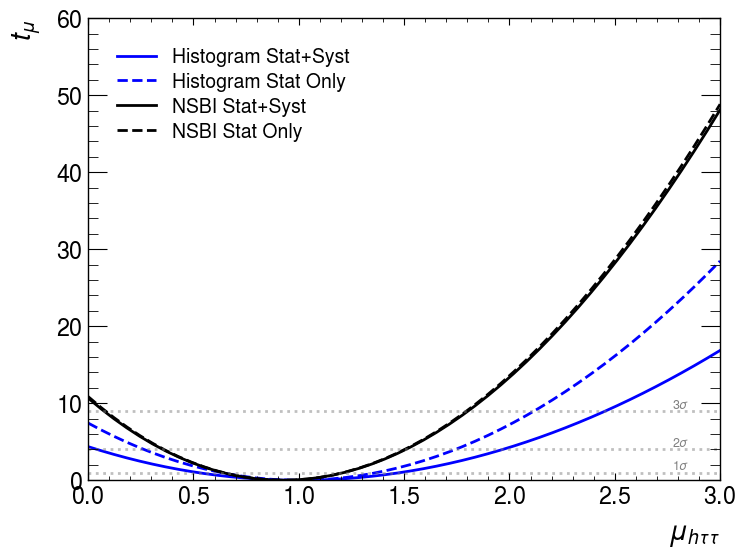

In [22]:
importlib.reload(sys.modules['nsbi_common_utils.inference'])
from nsbi_common_utils.inference import plot_NLL_scans

parameter_label = r'$\mu_{h\tau\tau}$'
list_scan_points = [scan_points_hist, scan_points_StatOnly_hist, scan_points_nsbi, scan_points_StatOnly_nsbi]
list_nll_values = [NLL_value_hist, NLL_value_StatOnly_hist, NLL_value_nsbi, NLL_value_StatOnly_nsbi]
list_labels = ["Histogram Stat+Syst", "Histogram Stat Only", "NSBI Stat+Syst", "NSBI Stat Only"]
list_linestyles = ["-", "--", "-", "--"]
list_colors = ["blue", "blue", "black", "black"]

plot_NLL_scans(parameter_label, list_scan_points, list_nll_values, list_labels, list_linestyles, list_colors)

Optimizing the analysis
===

**As we increase the number of parameters, the robustness of the density ratio modelling becomes more important. Building ensembles and optimizing preselections are important. Each of the $O(100)$ nuisance paramters typical in an LHC analysis needs to be checked for bias.**

Things that can be optimized for better convergence:

- Generate more simulated events for better modelling.
- Tighter preselections - removing more of the background-rich phase space $p_{ref}\sim 0$ that can cause numerical instabilites, removing phase space regions with low Monte Carlo statistics or that are difficult to model, etc.
- Add more input features for easier signal-background separation.
- Changing the hyperparameters of the various NNs used in the modelling.
- Training ensembles of NNs


# Need for JIT

While the time and function call seem negligible in this fit with only 3 parameters, JIT compilation becomes **essential** in a fit with $O(100)$ parameters typical in an LHC fit. **Without the compiled functions, the fit can go on for weeks!**

Additional modules to be added
===


- **Neyman Construction**

  Neyman construction requires sampling pseudo-experiments from the Asimov dataset and fitting parameters for each of the pseudo-experiment. The detailed method for performing this in an unbinned NSBI analysis is given in the ATLAS paper (https://arxiv.org/pdf/2412.01600).

  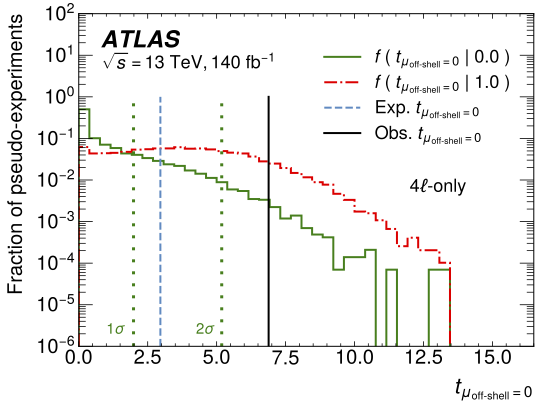

  The fitting of parameters for each of the hundreds of thousands of pseudo-experiments in a typical Neyman Construction, however, is computationally expensive and needs optimized workflows that were built for the ATLAS analysis and will be included in the tutorial soon.

- **Monte Carlo Statistical Uncertainties**

  To account for the uncertainties due to the limited Monte Carlo statistics used in the training data, a novel technique inspired by the spurious signals method and model ensembling was developed for the ATLAS publication. The detailed method for performing this in an unbinned NSBI analysis is given in the ATLAS papers and the corresponding modules will be added soon (requires ensemble training).


More Diagnostics
===

- **Signal injection tests**

  By fitting parameters with truth Asimov data generated at various values of the model parameters, ensure closure of the best fit values within Monte Carlo statistical uncertainties.
  
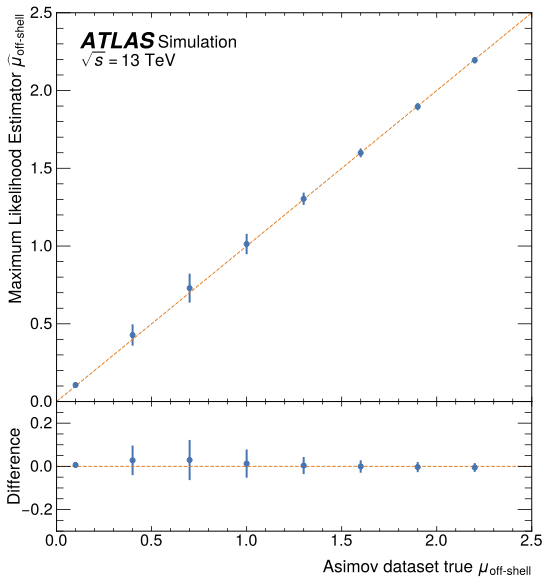

- **Data-MC validations**

  Detailed data-MC validations are perfromed both pre- and post-unblinding to verify the NNs as well as identify phase space regions associated with any data-MC differences.
  
  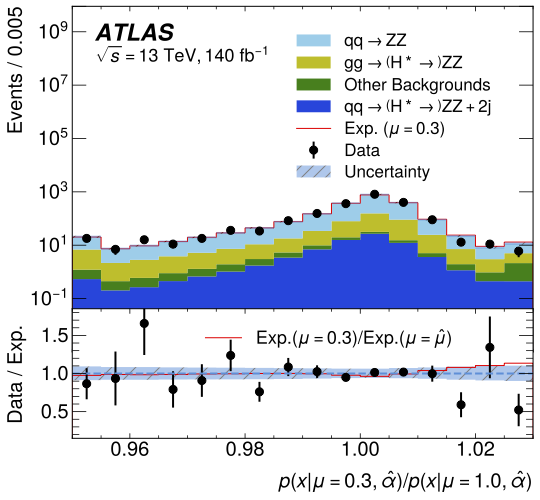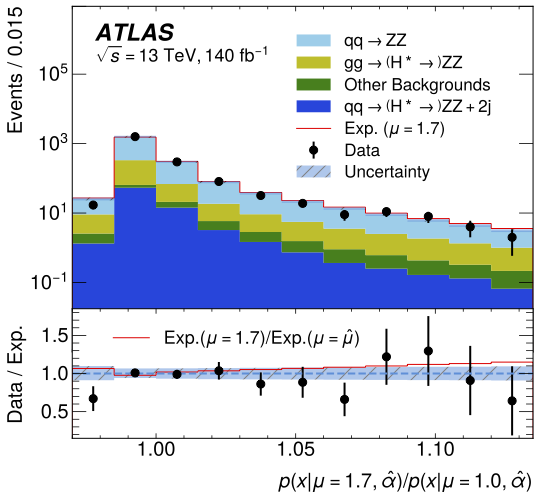